In [1]:
import pandas as pd #'version 1.2.4'
import numpy as np #'version 1.21.0'
from basico import * #'version 0.36'
import random
import matplotlib.pyplot as plt #'version 3.3.4'
import seaborn as sns #'version 0.11.1'
from scipy.ndimage.filters import gaussian_filter



<ipython-input-1-14ed94af5ab5>:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
# function for sorting lists based on values in another lsit
def sort_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)]
    return z

In [3]:
# define model names

name_base =  ["NMGPL_Model", "NPMGL_Model", "NMPGL_Model", "NGPML_Model", "NGMPL_Model"] 

In [4]:
data = np.array([4347, 2087, 2348, 1304, 3957]) # data from literature to compare simulations to


In [8]:
name_base = sort_list(name_base, data)[::-1]
data = sorted(data)[::-1]

In [9]:
# add the extensions to the base names to load in the data for different models
manual_models = [x + ".xml" for x in name_base]
ODE_fit_models = [x + "_v2.xml" for x in name_base]
stochastic_model_data = [x + "_SSA_10000sims.csv" for x in name_base]

In [7]:
# go through each set of parameters and calculate the MSE
preds = []
for tmod in manual_models:
    mod = load_model(tmod)
    tc = basico.run_time_course(duration=57000, start_time=0, stepsize=1000, method="LSODA")
    preds.append(tc["V"].loc[57000])
    remove_datamodel(mod)
preds = np.array(preds)

In [8]:
print("Manually Adjusted Parameters")
for i, name in enumerate(name_base):
    name = name.split("_")[0]
    print(f"{name} model prediction: {preds[i]}")
print(f"MSE: {np.mean((preds - data)**2)}")

Manually Adjusted Parameters
NMGPL model prediction: 768.6112067451138
NGMPL model prediction: 1892.8841646181759
NMPGL model prediction: 571.7405117414675
NPMGL model prediction: 1892.774888253854
NGPML model prediction: 3050.078936691163
MSE: 4661410.670876795


In [9]:
preds = []
for tmod in ODE_fit_models:
    mod = load_model(tmod)
    tc = basico.run_time_course(duration=57000, start_time=0, stepsize=1000, method="LSODA")
    preds.append(tc["V"].loc[57000])
    remove_datamodel(mod)
preds = np.array(preds)

In [10]:
print("ODE-Model")
for i, name in enumerate(name_base):
    name = name.split("_")[0]
    print(f"{name} model prediction: {preds[i]}")
print(f"MSE: {np.mean((preds - data)**2)}")

ODE-Model Parameters
NMGPL model prediction: 4190.924032677192
NGMPL model prediction: 3029.94118423632
NMPGL model prediction: 2688.040299413078
NPMGL model prediction: 2474.5433110358395
NGPML model prediction: 2122.915927861878
MSE: 364047.6551040689


In [10]:
dfs = []
for file in stochastic_model_data:
    dfs.append(pd.read_csv(file))

In [12]:
preds = []
for df in dfs:
    preds.append(list(df[df["Time"] == 57000]["V"]))
preds = np.array(preds)

In [13]:
print("Stochastic Model")
for i, name in enumerate(name_base):
    name = name.split("_")[0]
    print(f"{name} model prediction: {np.mean(preds[i])} ± {np.std(preds[i])/np.sqrt(len(preds[i])) * 1.96}")
print(f"MSE: {np.mean((np.mean(preds, axis = 1) - data)**2)}")

Stochastic Model
NMGPL model prediction: 4271.8701 ± 45.95693648035508
NGMPL model prediction: 3929.6845 ± 41.00801561035434
NMPGL model prediction: 2548.1532 ± 25.765880296147785
NPMGL model prediction: 1865.6243 ± 19.90150268903159
NGPML model prediction: 1327.5649 ± 10.47021874485353
MSE: 19202.889389400018


In [14]:
# select all negative stranded genome containing species
nsg = ["nsg", "nsg_N", "nsg_NP","nsg_NPL","nsg_NPLM","nsg_NPLMG","V"]

In [21]:
# select just the names of the variants
variants = [ x.split("_")[0] for x in name_base]
variants[3] = variants[3] + " (WT)"
variants

['NMGPL', 'NGMPL', 'NMPGL', 'NPMGL (WT)', 'NGPML']

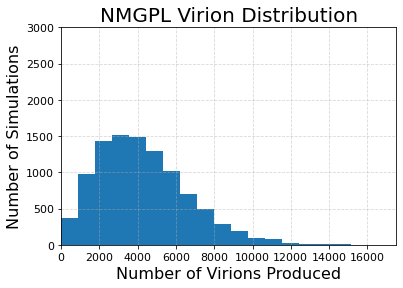

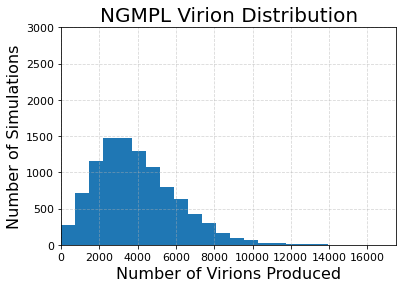

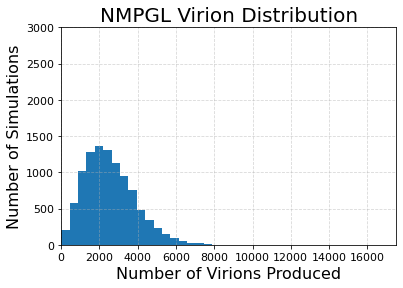

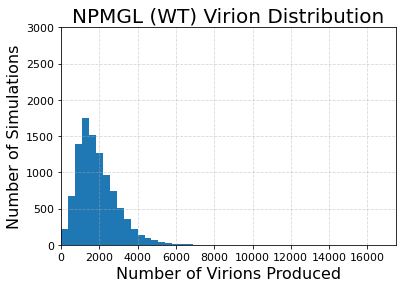

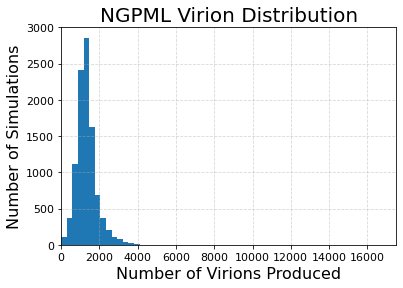

In [16]:
# visualize the virion distributions of the different variants
for i in range(5):
    plt.hist(preds[i], bins = 20)
    plt.xlim(0,17500)
    plt.ylim(0,3000)
    plt.xlabel("Number of Virions Produced", fontsize=16)
    plt.ylabel("Number of Simulations", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.5)
    title_font = {
    'fontsize': 20,
    'fontweight': 'bold',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center',
    'verticalalignment': 'bottom',
    'y': 10
}
    plt.yticks(fontsize=11)
    plt.xticks(fontsize=11)
    plt.title(f'{variants[i]} Virion Distribution', fontsize=20)
    plt.savefig(f'{variants[i]}_vir_distribution.svg',  dpi=600, bbox_inches='tight')
    plt.show()

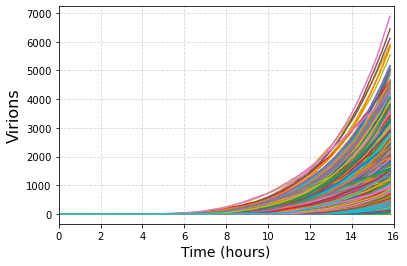

In [51]:
# plot indivdual trajectories from the wildtype

nsg_trajectories = []

for df in dfs[3:4]:
    #df = pd.concat([np.sum(df[nsg], axis = 1), df["Time"], df["iteration"]], axis = 1)
    df = pd.concat([df["V"], df["Time"], df["iteration"]], axis = 1)
    for i in np.unique(df["iteration"])[0:1000]:
        df_temp = df[df["iteration"] == i]
        plt.plot(df_temp.iloc[:,1]/3600,df_temp.iloc[:,0])
plt.xlabel("Time (hours)",fontsize=14)
plt.xlim([0,16])
plt.ylabel("Virions", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('V_simulations.svg', dpi=600,bbox_inches='tight')

In [19]:
# grab data for virion production, time until early phase is left, and mRNA counts

dfs_exp = []
dfs_vend = []
dfs_mN = []
dfs_mP = []
dfs_mM= []
dfs_mG= []
dfs_mL= []
for df in dfs:
    df_temp = df[df["V"] > 1]
    timer_to_exp = []
    vend = []
    mN = []
    mP = []
    mM = []
    mG = []
    mL = []
    for i in np.unique(df_temp["iteration"]):
        timer_to_exp.append(df_temp[df_temp["iteration"] == i]["Time"].iloc[0])
        vend.append(float(df[(df["iteration"] == i) & (df["Time"] == 57000)]["V"]))
        mN.append(df_temp[df_temp["iteration"] == i]["mN"].iloc[0])
        mP.append(df_temp[df_temp["iteration"] == i]["mP"].iloc[0])
        mM.append(df_temp[df_temp["iteration"] == i]["mM"].iloc[0])
        mG.append(df_temp[df_temp["iteration"] == i]["mG"].iloc[0])
        mL.append(df_temp[df_temp["iteration"] == i]["mL"].iloc[0])
    dfs_exp.append(timer_to_exp)
    dfs_vend.append(vend)
    dfs_mN.append(mN)
    dfs_mP.append(mP)
    dfs_mM.append(mM)
    dfs_mG.append(mG)
    dfs_mL.append(mL)

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


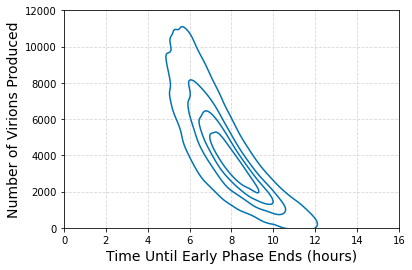

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


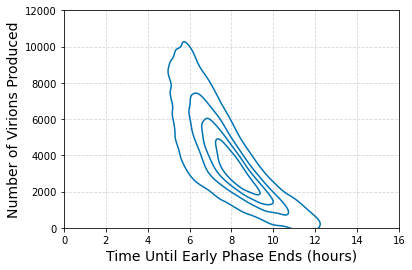

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


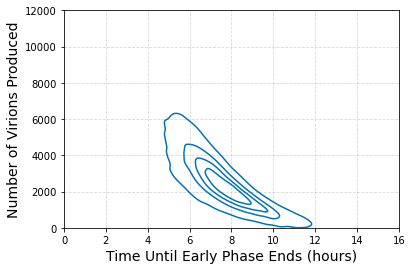

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


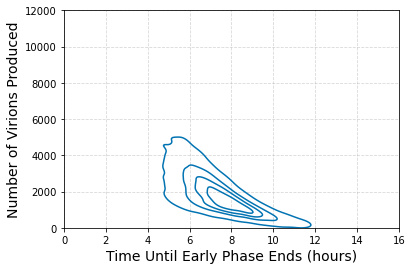

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


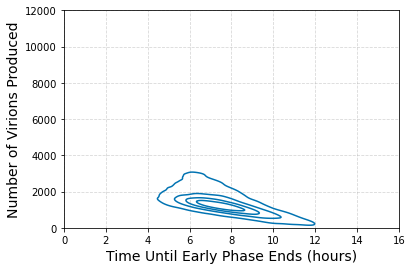

In [52]:
# plot the time to the end of the early phase vs the number of virions produced
colors = sns.color_palette("colorblind", 5)

for i in range(5):
    time = [ x/3600 for x in dfs_exp[i]]
    sns.kdeplot(time, dfs_vend[i], alpha=1, color=colors[0],levels=5)
    plt.ylim([0,12000])
    plt.xlim([0,16])
    plt.xlabel("Time Until Early Phase Ends (hours)", fontsize=14)
    plt.ylabel("Number of Virions Produced", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(f'{variants[i]}_vir_vs_exp.svg', dpi=600,bbox_inches='tight')
    plt.show()

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

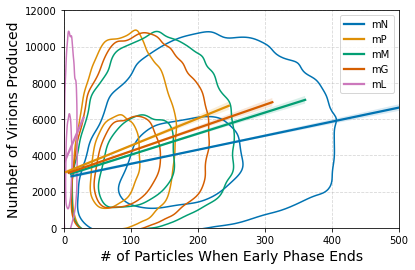

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

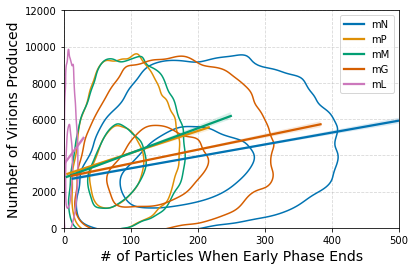

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

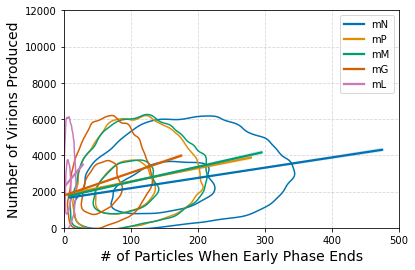

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

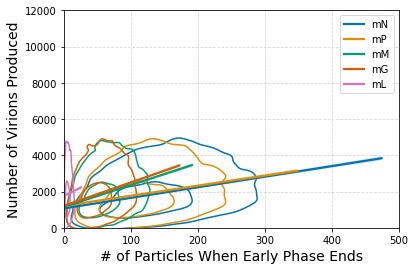

/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/connorking/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

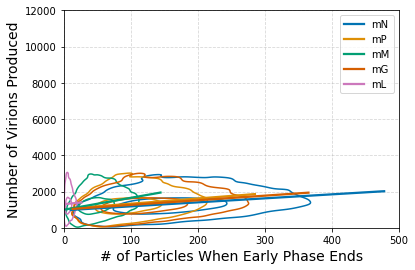

In [20]:
# plot the time to the number of mRNA when early phase is left vs the number of virions produced

for i in range(5):
    sns.kdeplot(dfs_mN[i], dfs_vend[i],  alpha=1, color=colors[0], levels=3)
    sns.regplot(dfs_mN[i], dfs_vend[i], color=colors[0],ci=95,scatter=False)
    sns.kdeplot(dfs_mP[i], dfs_vend[i],  alpha=1,color=colors[1],  levels=3)
    sns.regplot(dfs_mP[i], dfs_vend[i], color=colors[1],ci=95,scatter=False)
    sns.kdeplot(dfs_mM[i], dfs_vend[i],  alpha=1, color=colors[2], levels=3)
    sns.regplot(dfs_mM[i], dfs_vend[i], color=colors[2],ci=95,scatter=False)
    sns.kdeplot(dfs_mG[i], dfs_vend[i],  alpha=1, color=colors[3], levels=3)
    sns.regplot(dfs_mG[i], dfs_vend[i], color=colors[3],ci=95,scatter=False)
    sns.kdeplot(dfs_mL[i], dfs_vend[i],  alpha=1,color=colors[4],  levels=3)
    sns.regplot(dfs_mL[i], dfs_vend[i], color=colors[4],ci=95,scatter=False)
    plt.ylim([0,12000])
    plt.xlim([0,500])
    plt.xlabel("# of Particles When Early Phase Ends", fontsize=14)
    plt.ylabel("Number of Virions Produced", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(["mN", "mP", "mM", "mG", "mL"])
    plt.savefig(f'{variants[i]}_vir_vs_mRNA.svg', dpi=600,bbox_inches='tight')
    plt.show()

In [21]:
# function for calculating r
def calc_rsq(y_true, x_true):
    a,b = np.polyfit(x_true, y_true,1)
    y_pred = np.array(x_true) * a + b
    corr_matrix = numpy.corrcoef(y_true, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return corr

In [22]:
# calculate r for every mRNA in every variant
for i in range(5):
    print(variants[i])
    y_true = np.array(dfs_vend[i])
    print(calc_rsq(y_true, np.array(dfs_mN[i])))
    print(calc_rsq(y_true, np.array(dfs_mP[i])))
    print(calc_rsq(y_true, np.array(dfs_mM[i])))
    print(calc_rsq(y_true, np.array(dfs_mG[i])))
    print(calc_rsq(y_true, np.array(dfs_mL[i])))

NMGPL
0.26865179769358805
0.2100937627018956
0.2504332770057009
0.2345711846096526
0.1594554292574538
NGMPL
0.2527250001257527
0.189252857868872
0.23163422854714028
0.22023606290178743
0.1032988375579373
NMPGL
0.29284894186785354
0.21975368802446782
0.26802644548681026
0.24430667968202405
0.12927270045830458
NPMGL (WT)
0.324960658704131
0.2522591972795217
0.2980877320928542
0.27310109586402803
0.05788778711170205
NGPML
0.28140568316673503
0.21093471750534512
0.2641696382015591
0.2439347591474769
0.02523593714902947
